In [1]:
import pathlib
import tensorflow as tf
import pickle
import random
import re
import unicodedata

### Downloading Dataset

In [2]:
# download dataset
text_file = tf.keras.utils.get_file(
    fname="fra-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract=True,
)
# show where the file is located now
text_file = pathlib.Path(text_file).parent / "fra.txt"
print(text_file)

C:\Users\DELL\.keras\datasets\fra.txt


In [3]:
# Open the file extracted. You should verify that the format of each line is like the above
with open(text_file, "r", encoding="utf-8") as file:
    for _ in range(10):
        print(file.readline().strip())

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !
Jump.	Saute.
Stop!	Ça suffit !


### Text Normalization

In [4]:
def normalize(line):
    """Normalize a line of text and split into two at the tab character"""
    line = unicodedata.normalize("NFKC", line.strip().lower())
    line = re.sub(r"^([^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(\s[^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(?!\s)([^ \w])$", r" \1", line)
    line = re.sub(r"(?!\s)([^ \w]\s)", r" \1", line)
    eng, fra = line.split("\t")
    fra = "[start] " + fra + " [end]"
    return eng, fra

In [5]:
# normalize each line and separate into English and French
text_pairs = []
with open(text_file, encoding='utf-8') as fp:
    for line in fp:
        text_pairs.append(normalize(line))

In [6]:
# print some samples
for _ in range(5):
    print(random.choice(text_pairs))

with open("text_pairs.pickle", "wb") as fp:
    pickle.dump(text_pairs, fp)

('i got a shave and a haircut .', '[start] je me suis fait raser et coiffer . [end]')
('i always drink a glass of milk before going to sleep .', "[start] je bois toujours un verre de lait avant d'aller me coucher . [end]")
("you're tom's students , right ?", "[start] vous êtes les étudiants de tom , n'est-ce pas  ?  [end]")
('i got really mad .', '[start] je me suis vraiment mis en colère . [end]')
('they clung together for warmth .', '[start] elles se cramponnèrent les unes aux autres pour conserver leur chaleur . [end]')


### Data Exploration

In [7]:
with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)

# count tokens
eng_tokens, fra_tokens = set(), set()
eng_maxlen, fra_maxlen = 0, 0
for eng, fra in text_pairs:
    eng_tok, fra_tok = eng.split(), fra.split()
    eng_maxlen = max(eng_maxlen, len(eng_tok))
    fra_maxlen = max(fra_maxlen, len(fra_tok))
    eng_tokens.update(eng_tok)
    fra_tokens.update(fra_tok)
print(f"Total English tokens: {len(eng_tokens)}")
print(f"Total French tokens: {len(fra_tokens)}")
print(f"Max English length: {eng_maxlen}")
print(f"Max French length: {fra_maxlen}")
print(f"{len(text_pairs)} total pairs")

Total English tokens: 14969
Total French tokens: 29219
Max English length: 51
Max French length: 60
167130 total pairs


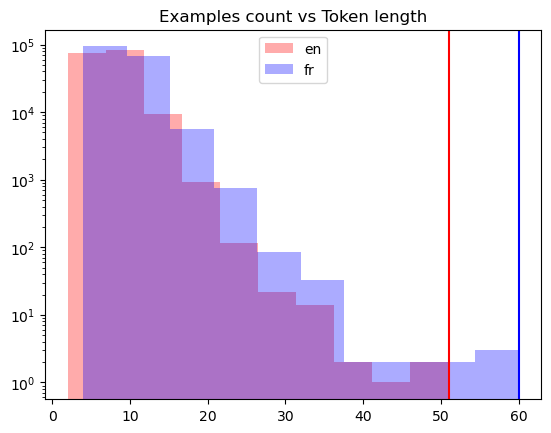

In [8]:
import matplotlib.pyplot as plt

# histogram of sentence length in tokens
en_lengths = [len(eng.split()) for eng, fra in text_pairs]
fr_lengths = [len(fra.split()) for eng, fra in text_pairs]
 
plt.hist(en_lengths, label="en", color="red", alpha=0.33)
plt.hist(fr_lengths, label="fr", color="blue", alpha=0.33)
plt.yscale("log")     # sentence length fits Benford"s law
plt.ylim(plt.ylim())  # make y-axis consistent for both plots
plt.plot([max(en_lengths), max(en_lengths)], plt.ylim(), color="red")
plt.plot([max(fr_lengths), max(fr_lengths)], plt.ylim(), color="blue")
plt.legend()
plt.title("Examples count vs Token length")
plt.show()

### Vectorization and Making Datasets

In [9]:
# Load normalized sentence pairs
with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)

In [10]:
# train-test-val split of randomized sentence pairs
random.shuffle(text_pairs)
n_val = int(0.15*len(text_pairs))
n_train = len(text_pairs) - 2*n_val
train_pairs = text_pairs[:n_train]
val_pairs = text_pairs[n_train:n_train+n_val]
test_pairs = text_pairs[n_train+n_val:]

# Parameter determined after analyzing the input data
vocab_size_en = 10000
vocab_size_fr = 20000
seq_length = 20

In [11]:
from tensorflow.keras.layers import TextVectorization

# Create vectorizer
eng_vectorizer = TextVectorization(
    max_tokens=vocab_size_en,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length,
)
fra_vectorizer = TextVectorization(
    max_tokens=vocab_size_fr,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length + 1
)

In [12]:
# train the vectorization layer using training dataset
train_eng_texts = [pair[0] for pair in train_pairs]
train_fra_texts = [pair[1] for pair in train_pairs]
eng_vectorizer.adapt(train_eng_texts)
fra_vectorizer.adapt(train_fra_texts)
 
# save for subsequent steps
with open("vectorize.pickle", "wb") as fp:
    data = {
        "train": train_pairs,
        "val":   val_pairs,
        "test":  test_pairs,
        "engvec_config":  eng_vectorizer.get_config(),
        "engvec_weights": eng_vectorizer.get_weights(),
        "fravec_config":  fra_vectorizer.get_config(),
        "fravec_weights": fra_vectorizer.get_weights(),
    }
    pickle.dump(data, fp)

Shape = (batch size, sequence length)

In [13]:
# load text data and vectorizer weights
with open("vectorize.pickle", "rb") as fp:
    data = pickle.load(fp)

train_pairs = data["train"]
val_pairs = data["val"]
test_pairs = data["test"]   # not used

eng_vectorizer = TextVectorization.from_config(data["engvec_config"])
eng_vectorizer.set_weights(data["engvec_weights"])
fra_vectorizer = TextVectorization.from_config(data["fravec_config"])
fra_vectorizer.set_weights(data["fravec_weights"])

# set up Dataset object
def format_dataset(eng, fra):
    eng = eng_vectorizer(eng)
    fra = fra_vectorizer(fra)
    source = {"encoder_inputs": eng,
              "decoder_inputs": fra[:, :-1]}
    target = fra[:, 1:]
    return (source, target)

def make_dataset(pairs, batch_size=64):
    """Create TensorFlow Dataset for the sentence pairs"""
    # aggregate sentences using zip(*pairs)
    eng_texts, fra_texts = zip(*pairs)
    # convert them into list, and then create tensors
    dataset = tf.data.Dataset.from_tensor_slices((list(eng_texts), list(fra_texts)))
    return dataset.shuffle(2048) \
                  .batch(batch_size).map(format_dataset) \
                  .prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

# test the dataset
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["encoder_inputs"][0]: {inputs["encoder_inputs"][0]}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"][0]: {inputs["decoder_inputs"][0]}')
    print(f"targets.shape: {targets.shape}")
    print(f"targets[0]: {targets[0]}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["encoder_inputs"][0]: [ 236    9  270 1711    5    8 2864    2    0    0    0    0    0    0
    0    0    0    0    0    0]
inputs["decoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"][0]: [  2  95   1 265  13 186  10  19 468   4   3   0   0   0   0   0   0   0
   0   0]
targets.shape: (64, 20)
targets[0]: [ 95   1 265  13 186  10  19 468   4   3   0   0   0   0   0   0   0   0
   0   0]


### Positional Encoding Matrix

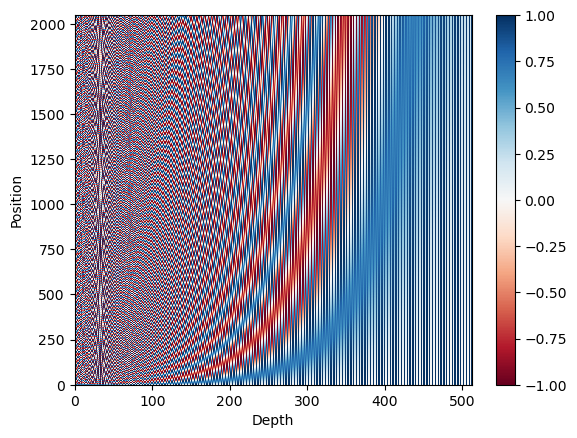

In [14]:
import matplotlib.pyplot as plt
import numpy as np


def pos_enc_matrix(L, d, n=10000):
    """Create positional encoding matrix"""
    assert d % 2 == 0     # Output dimension needs to be an even integer
    d2 = d//2
    P = np.zeros((L, d))
    k = np.arange(L).reshape(-1, 1)     # L-column vector
    i = np.arange(d2).reshape(1, -1)    # d-row vector
    denom = np.power(n, -i/d2)          # n**(-2*i/d)
    args = k * denom                    # (L,d) matrix
    P[:, ::2] = np.sin(args)
    P[:, 1::2] = np.cos(args)
    return P

# Heatmap representation of the positional encoding matrix
# Plot the positional encoding matrix
pos_matrix = pos_enc_matrix(L=2048, d=512)
assert pos_matrix.shape == (2048, 512)
plt.pcolormesh(pos_matrix, cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

with open("posenc-2048-512.pickle", "wb") as fp:
    pickle.dump(pos_matrix, fp)

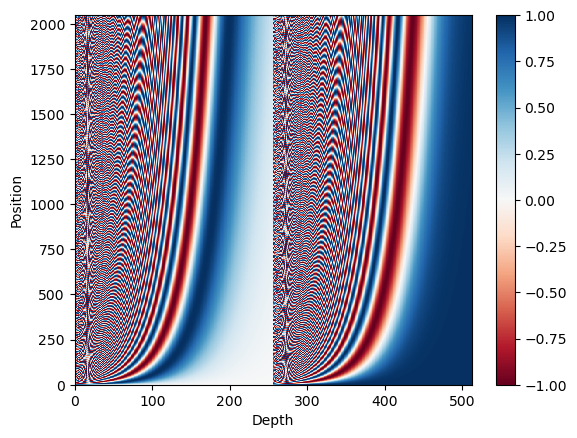

In [15]:
with open("posenc-2048-512.pickle", "rb") as fp:
    pos_matrix = pickle.load(fp)
assert pos_matrix.shape == (2048, 512)
# Plot the positional encoding matrix, alternative way
plt.pcolormesh(np.hstack([pos_matrix[:, ::2], pos_matrix[:, 1::2]]), cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

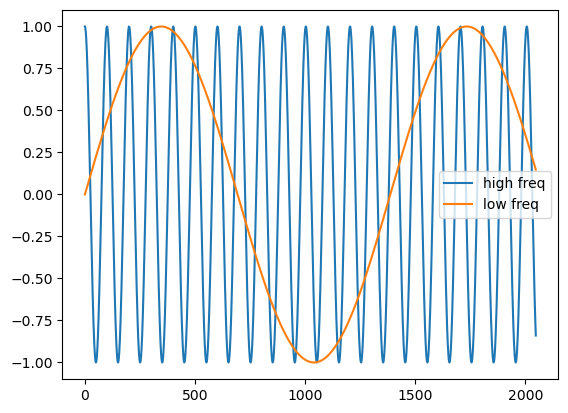

In [16]:
plt.plot(pos_matrix[:, 155], label="high freq")
plt.plot(pos_matrix[:, 300], label="low freq")
plt.legend()
plt.show()

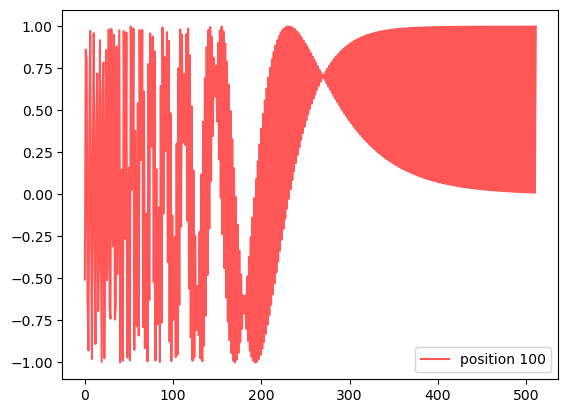

In [17]:
with open("posenc-2048-512.pickle", "rb") as fp:
    pos_matrix = pickle.load(fp)
assert pos_matrix.shape == (2048, 512)
# Plot two curves from different position
plt.plot(pos_matrix[100], alpha=0.66, color="red", label="position 100")
plt.legend()
plt.show()

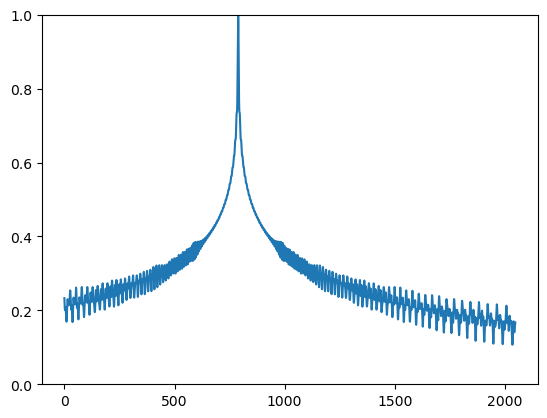

In [18]:
with open("posenc-2048-512.pickle", "rb") as fp:
    pos_matrix = pickle.load(fp)
assert pos_matrix.shape == (2048, 512)
# Show the dot product between different normalized positional vectors
pos_matrix /= np.linalg.norm(pos_matrix, axis=1, keepdims=True)
p = pos_matrix[789]  # all vectors compare to vector at position 789
dots = pos_matrix @ p
plt.plot(dots)
plt.ylim([0, 1])
plt.show()

### Positional Encoding Layer

In [19]:
import numpy as np
import tensorflow as tf

def pos_enc_matrix(L, d, n=10000):
    #Create positional encoding matrix
    #L: Input dimension (length)
    #d: Output dimension (depth), even only
    #n: Constant for the sinusoidal functions
   
    assert d % 2 == 0 # Output dimension needs to be an even integer
    d2 = d//2
    P = np.zeros((L, d))
    k = np.arange(L).reshape(-1, 1)     # L-column vector
    i = np.arange(d2).reshape(1, -1)    # d-row vector
    denom = np.power(n, -i/d2)          # n**(-2*i/d)
    args = k * denom                    # (L,d) matrix
    P[:, ::2] = np.sin(args)
    P[:, 1::2] = np.cos(args)
    return P


Positional embedding layer
- Assume tokenized input 
- Transform into embedding
- Return positional-encoded output

Arg: 
- sequence_length: Input sequence length
- vocab_size: Input vocab size, for setting up embedding matrix
- embed_dim: Embedding vector size, for setting up embedding matrix

In [20]:
class PositionalEmbedding(tf.keras.layers.Layer):

    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):

        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim     # d_model in paper
        # token embedding layer: Convert integer token to D-dim float vector
        self.token_embeddings = tf.keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim, mask_zero=True
        )
        # positional embedding layer: a matrix of hard-coded sine values
        matrix = pos_enc_matrix(sequence_length, embed_dim)
        self.position_embeddings = tf.constant(matrix, dtype="float32")

    def call(self, inputs):
        #Input tokens convert into embedding vectors then superimposed with position vectors
        embedded_tokens = self.token_embeddings(inputs)
        return embedded_tokens + self.position_embeddings

    # this layer is using an Embedding layer, which can take a mask
    def compute_mask(self, *args, **kwargs):
        return self.token_embeddings.compute_mask(*args, **kwargs)

    def get_config(self):
        # to make save and load a model using custom layer possible
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config

In [21]:
# train_ds = make_dataset(train_pairs)

vocab_size_en = 10000
seq_length = 20

# test the dataset
for inputs, targets in train_ds.take(1):
    print(inputs["encoder_inputs"])
    embed_en = PositionalEmbedding(seq_length, vocab_size_en, embed_dim=512)
    en_emb = embed_en(inputs["encoder_inputs"])
    print(en_emb.shape)
    print(en_emb._keras_mask)

tf.Tensor(
[[  12   38  416 ...    0    0    0]
 [   3  529   79 ...    0    0    0]
 [   3   74   98 ...    0    0    0]
 ...
 [  43   55 1793 ...    0    0    0]
 [  10  128  325 ...    0    0    0]
 [  10   71   94 ...    0    0    0]], shape=(64, 20), dtype=int64)
(64, 20, 512)
tf.Tensor(
[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]], shape=(64, 20), dtype=bool)


### Transformer Building Blocks

#### Self-attention layers at transformer encoder and decoder
-> Assumes its input is the output from positional encoding layer

Args:
- prefix (str): The prefix added to the layer names
- masked (bool): whether to use causal mask. Should be False on encoder and True on decoder. When True, a mask will be applied such that each location only has access to the locations before it

In [22]:
def self_attention(input_shape, prefix="att", mask=False, **kwargs):

    # create layers
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in1")
    attention = tf.keras.layers.MultiHeadAttention(name=f"{prefix}_attn1", **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm1")
    add = tf.keras.layers.Add(name=f"{prefix}_add1")
    # functional API to connect input to output
    attout = attention(query=inputs, value=inputs, key=inputs,
                       use_causal_mask=mask)
    outputs = norm(add([inputs, attout]))
    # create model and return
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f"{prefix}_att")
    return model

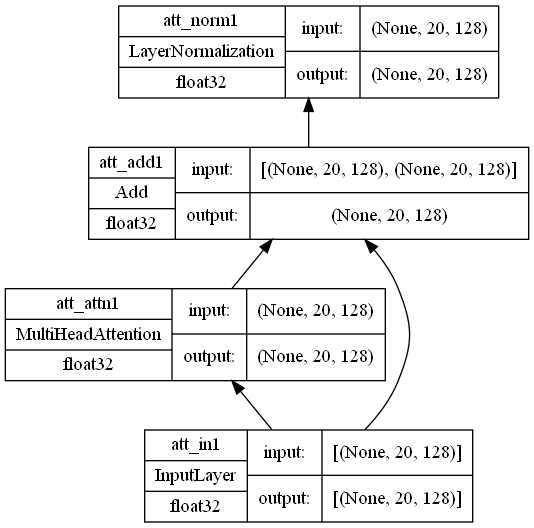

In [23]:
seq_length = 20
key_dim = 128
num_heads = 8

model = self_attention(input_shape=(seq_length, key_dim),
                       num_heads=num_heads, key_dim=key_dim)
tf.keras.utils.plot_model(model, "self-attention.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

#### Cross-attention layers at transformer decoder. 
-> Assumes its input is the output from positional encoding layer at decoder and context is the final output from encoder

Args:
- prefix (str): The prefix added to the layer names


In [25]:
def cross_attention(input_shape, context_shape, prefix="att", **kwargs):

    # create layers
    context = tf.keras.layers.Input(shape=context_shape, dtype='float32',
                                    name=f"{prefix}_ctx2")
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in2")
    attention = tf.keras.layers.MultiHeadAttention(name=f"{prefix}_attn2", **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm2")
    add = tf.keras.layers.Add(name=f"{prefix}_add2")
    # functional API to connect input to output
    attout = attention(query=inputs, value=context, key=context)
    outputs = norm(add([attout, inputs]))
    # create model and return
    model = tf.keras.Model(inputs=[(context, inputs)], outputs=outputs,
                           name=f"{prefix}_cross")
    return model

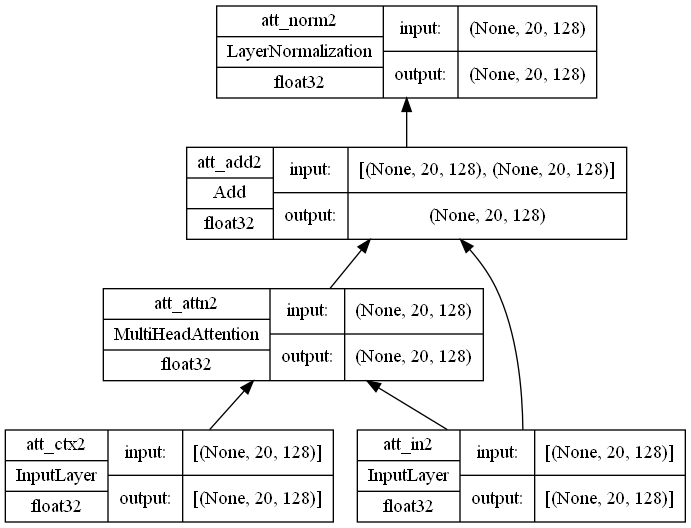

In [26]:
seq_length = 20
key_dim = 128
num_heads = 8

model = cross_attention(input_shape=(seq_length, key_dim),
                        context_shape=(seq_length, key_dim),
                        num_heads=num_heads, key_dim=key_dim)
tf.keras.utils.plot_model(model, "cross-attention.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

#### Feed-forward layers at transformer encoder and decoder 
-> Assumes its input is the output from an attention layer with add & norm, the output is the output of one encoder or decoder block

Args:

- model_dim (int): Output dimension of the feed-forward layer, which is also the output dimension of the encoder/decoder block
- ff_dim (int): Internal dimension of the feed-forward layer dropout (float): Dropout rate
- prefix (str): The prefix added to the layer names

In [27]:
def feed_forward(input_shape, model_dim, ff_dim, dropout=0.1, prefix="ff"):

    # create layers
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in3")
    dense1 = tf.keras.layers.Dense(ff_dim, name=f"{prefix}_ff1", activation="relu")
    dense2 = tf.keras.layers.Dense(model_dim, name=f"{prefix}_ff2")
    drop = tf.keras.layers.Dropout(dropout, name=f"{prefix}_drop")
    add = tf.keras.layers.Add(name=f"{prefix}_add3")
    # functional API to connect input to output
    ffout = drop(dense2(dense1(inputs)))
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm3")
    outputs = norm(add([inputs, ffout]))
    # create model and return
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f"{prefix}_ff")
    return model

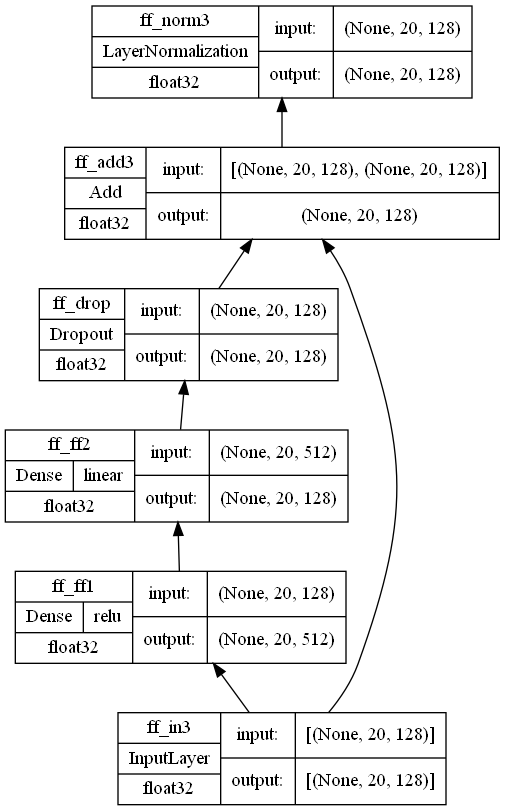

In [28]:
seq_length = 20
key_dim = 128
ff_dim = 512

model = feed_forward(input_shape=(seq_length, key_dim),
                     model_dim=key_dim, ff_dim=ff_dim)
tf.keras.utils.plot_model(model, "feedforward.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

### Transformer Encoder and Decoder

One encoder unit 
- The input and output are in the same shape so we can daisy chain multiple encoder units into one larger encoder

In [30]:
# the building block functions from Lesson 06
def encoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix="enc", **kwargs):

    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{prefix}_in0"),
        self_attention(input_shape, prefix=prefix, key_dim=key_dim, mask=False, **kwargs),
        feed_forward(input_shape, key_dim, ff_dim, dropout, prefix),
    ], name=prefix)
    return model

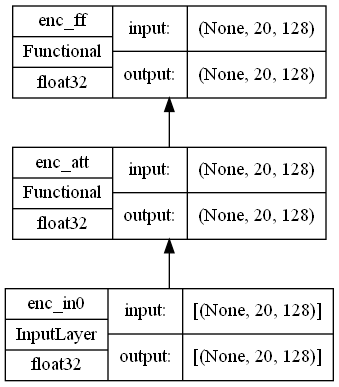

In [31]:
seq_length = 20
key_dim = 128
ff_dim = 512
num_heads = 8

model = encoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim,
                num_heads=num_heads)
tf.keras.utils.plot_model(model, "encoder.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

One decoder unit
- The input and output are in the same shape so we can daisy chain multiple decoder units into one larger decoder. 
- The context vector is also assumed to be the same shape for convenience

In [32]:
def decoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix="dec", **kwargs):

    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in0")
    context = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                    name=f"{prefix}_ctx0")
    attmodel = self_attention(input_shape, key_dim=key_dim, mask=True,
                              prefix=prefix, **kwargs)
    crossmodel = cross_attention(input_shape, input_shape, key_dim=key_dim,
                                 prefix=prefix, **kwargs)
    ffmodel = feed_forward(input_shape, key_dim, ff_dim, dropout, prefix)
    x = attmodel(inputs)
    x = crossmodel([(context, x)])
    output = ffmodel(x)
    model = tf.keras.Model(inputs=[(inputs, context)], outputs=output, name=prefix)
    return model

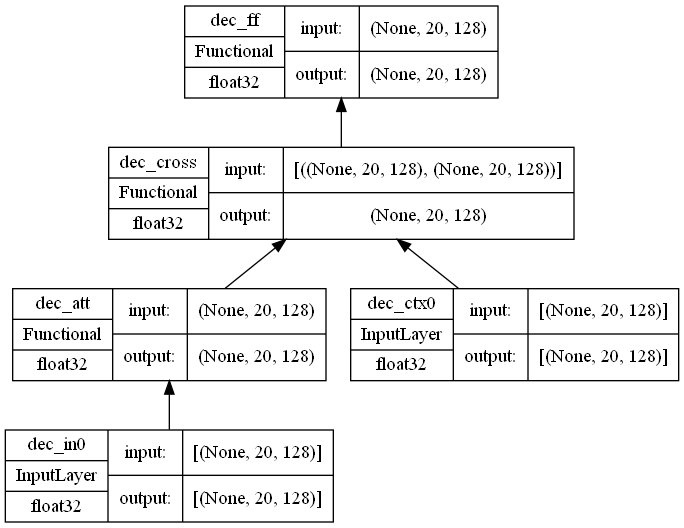

In [33]:
seq_length = 20
key_dim = 128
ff_dim = 512
num_heads = 8

model = decoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim,
                num_heads=num_heads)
tf.keras.utils.plot_model(model, "decoder.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

### Building a Transformer

In [35]:
def transformer(num_layers, num_heads, seq_len, key_dim, ff_dim, vocab_size_src,
                vocab_size_tgt, dropout=0.1, name="transformer"):
    embed_shape = (seq_len, key_dim)  # output shape of the positional embedding layer
    # set up layers
    input_enc = tf.keras.layers.Input(shape=(seq_len,), dtype="int32",
                                      name="encoder_inputs")
    input_dec = tf.keras.layers.Input(shape=(seq_len,), dtype="int32",
                                      name="decoder_inputs")
    embed_enc = PositionalEmbedding(seq_len, vocab_size_src, key_dim, name="embed_enc")
    embed_dec = PositionalEmbedding(seq_len, vocab_size_tgt, key_dim, name="embed_dec")
    encoders = [encoder(input_shape=embed_shape, key_dim=key_dim,
                        ff_dim=ff_dim, dropout=dropout, prefix=f"enc{i}",
                        num_heads=num_heads)
                for i in range(num_layers)]
    decoders = [decoder(input_shape=embed_shape, key_dim=key_dim,
                        ff_dim=ff_dim, dropout=dropout, prefix=f"dec{i}",
                        num_heads=num_heads)
                for i in range(num_layers)]
    final = tf.keras.layers.Dense(vocab_size_tgt, name="linear")
    # build output
    x1 = embed_enc(input_enc)
    x2 = embed_dec(input_dec)
    for layer in encoders:
        x1 = layer(x1)
    for layer in decoders:
        x2 = layer([x2, x1])
    output = final(x2)
    # XXX keep this try-except block
    try:
        del output._keras_mask
    except AttributeError:
        pass
    model = tf.keras.Model(inputs=[input_enc, input_dec], outputs=output, name=name)
    return model

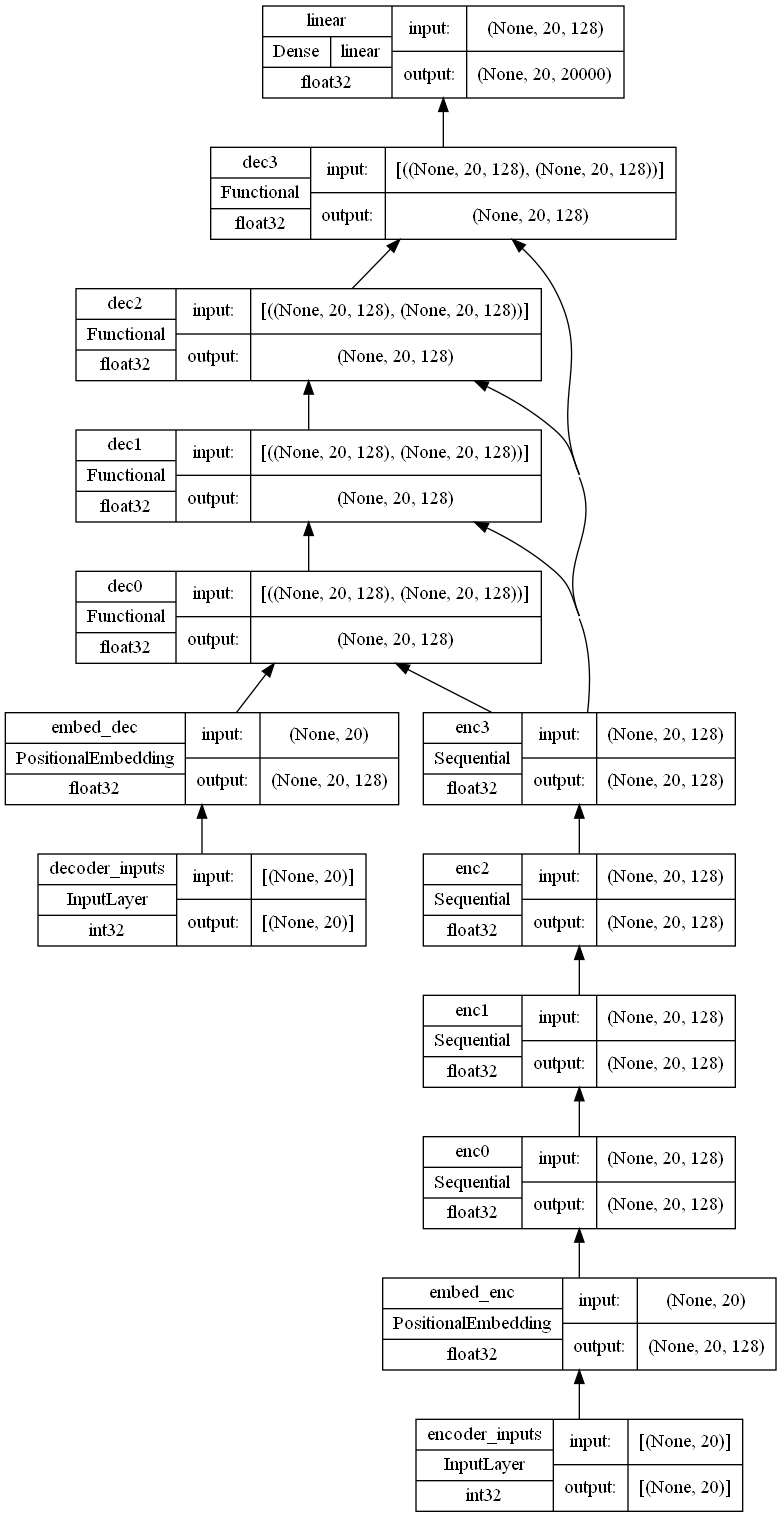

In [36]:
seq_len = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
vocab_size_en = 10000
vocab_size_fr = 20000
model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim,
                    vocab_size_en, vocab_size_fr, dropout)
tf.keras.utils.plot_model(model, "transformer.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

### Prepare the Transformer Model for Training

In [37]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    "Custom learning rate for Adam optimizer"
    def __init__(self, key_dim, warmup_steps=4000):
        super().__init__()
        self.key_dim = key_dim
        self.warmup_steps = warmup_steps
        self.d = tf.cast(self.key_dim, tf.float32)
 
    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)
 
    def get_config(self):
        # to make save and load a model using custom layer possible0
        config = {
            "key_dim": self.key_dim,
            "warmup_steps": self.warmup_steps,
        }
        return config

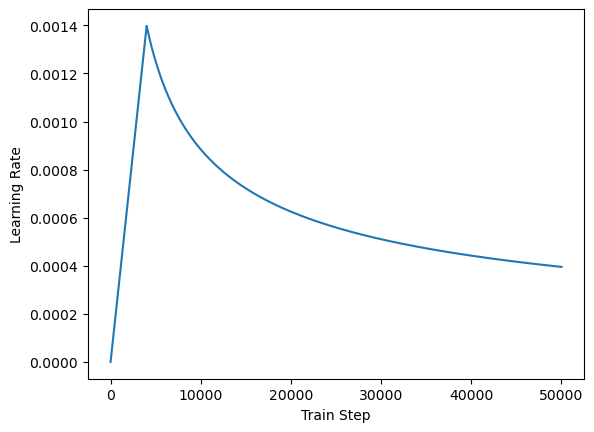

In [38]:
key_dim = 128
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
 
plt.plot(lr(tf.range(50000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

- It learns slowly at the beginning but accelerates as it learns It helps because the model is totally random at the beginning, and we cannot even trust the output much
- As we train the model enough, the result should be sufficiently sensible and thus you can learn faster to help convergence

- Define the loss metric and accuracy metric for training. 
- This model is special because we need to apply a mask to the output to calculate the loss and accuracy only on the non-padding elements.

In [39]:
def masked_loss(label, pred):
    mask = label != 0

    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [40]:
vocab_size_en = 10000
vocab_size_fr = 20000
seq_len = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim,
                    vocab_size_en, vocab_size_fr, dropout)
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, 20)]                 0         []                            
 )                                                                                                
                                                                                                  
 embed_enc (PositionalEmbed  (None, 20, 128)              1280000   ['encoder_inputs[0][0]']      
 ding)                                                                                            
                                                                                                  
 enc0 (Sequential)           (None, 20, 128)              659712    ['embed_enc[0][0]']           
                                                                                        

### Training the Transformer

Epoch 1/20
1828/1828 [==============================] - 2480s 1s/step - loss: 5.1992 - masked_accuracy: 0.3017 - val_loss: 3.1795 - val_masked_accuracy: 0.4694
Epoch 2/20
1828/1828 [==============================] - 2433s 1s/step - loss: 2.7235 - masked_accuracy: 0.5405 - val_loss: 2.2431 - val_masked_accuracy: 0.6014
Epoch 3/20
1828/1828 [==============================] - 2304s 1s/step - loss: 2.1090 - masked_accuracy: 0.6278 - val_loss: 1.8615 - val_masked_accuracy: 0.6621
Epoch 4/20
1828/1828 [==============================] - 2298s 1s/step - loss: 1.7492 - masked_accuracy: 0.6834 - val_loss: 1.6505 - val_masked_accuracy: 0.6994
Epoch 5/20
1828/1828 [==============================] - 2300s 1s/step - loss: 1.5795 - masked_accuracy: 0.7140 - val_loss: 1.5358 - val_masked_accuracy: 0.7171
Epoch 6/20
1828/1828 [==============================] - 2296s 1s/step - loss: 1.4582 - masked_accuracy: 0.7349 - val_loss: 1.4665 - val_masked_accuracy: 0.7306
Epoch 7/20
1828/1828 [==================

C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


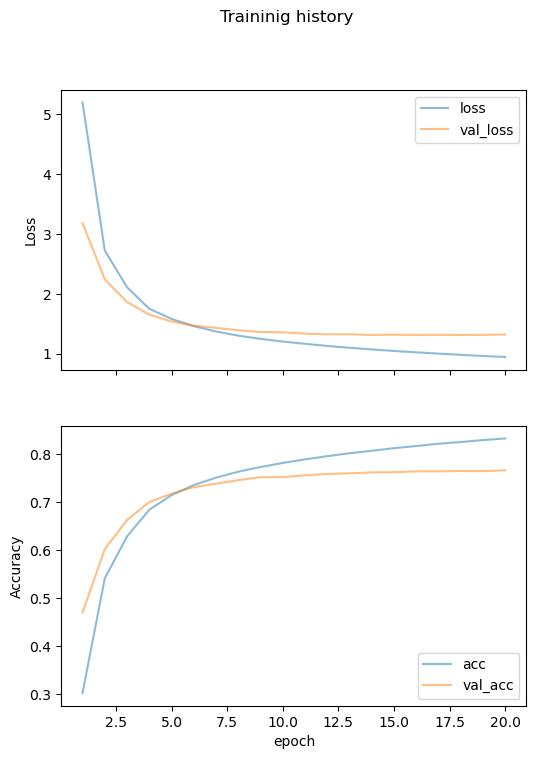

In [41]:
# Create and train the model
seq_len = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
vocab_size_en = 10000
vocab_size_fr = 20000

model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim,
                    vocab_size_en, vocab_size_fr, dropout)
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
epochs = 20
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

# Save the trained model
model.save("eng-fra-transformer.h5")

# Plot the loss and accuracy history
fig, axs = plt.subplots(2, figsize=(6, 8), sharex=True)
fig.suptitle('Traininig history')
x = list(range(1, epochs+1))
axs[0].plot(x, history.history["loss"], alpha=0.5, label="loss")
axs[0].plot(x, history.history["val_loss"], alpha=0.5, label="val_loss")
axs[0].set_ylabel("Loss")
axs[0].legend(loc="upper right")
axs[1].plot(x, history.history["masked_accuracy"], alpha=0.5, label="acc")
axs[1].plot(x, history.history["val_masked_accuracy"], alpha=0.5, label="val_acc")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("epoch")
axs[1].legend(loc="lower right")
plt.show()

### Inference from the Transformer Model

In [42]:
# Load the trained model
custom_objects = {"PositionalEmbedding": PositionalEmbedding,
                  "CustomSchedule": CustomSchedule,
                  "masked_loss": masked_loss,
                  "masked_accuracy": masked_accuracy}
with tf.keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model("eng-fra-transformer.h5")

# training parameters used
seq_len = 20
vocab_size_en = 10000
vocab_size_fr = 20000

In [43]:
# Create the translated sentence
def translate(sentence):
 
    enc_tokens = eng_vectorizer([sentence])
    lookup = list(fra_vectorizer.get_vocabulary())
    start_sentinel, end_sentinel = "[start]", "[end]"
    output_sentence = [start_sentinel]
    # generate the translated sentence word by word
    for i in range(seq_len):
        vector = fra_vectorizer([" ".join(output_sentence)])
        assert vector.shape == (1, seq_len+1)
        dec_tokens = vector[:, :-1]
        assert dec_tokens.shape == (1, seq_len)
        pred = model([enc_tokens, dec_tokens])
        assert pred.shape == (1, seq_len, vocab_size_fr)
        word = lookup[np.argmax(pred[0, i, :])]
        output_sentence.append(word)
        if word == end_sentinel:
            break
    return output_sentence 

In [44]:
test_count = 20
for n in range(test_count):
    english_sentence, french_sentence = random.choice(test_pairs)
    translated = translate(english_sentence)
    print(f"Test {n}:")
    print(f"{english_sentence}")
    print(f"== {french_sentence}")
    print(f"-> {' '.join(translated)}")
    print()

Test 0:
i work every day except sunday .
== [start] je travaille tous les jours sauf le dimanche . [end]
-> [start] je travaille tous les jours sauf le dimanche . [end]

Test 1:
we're still not sure .
== [start] nous ne sommes pas encore sûrs . [end]
-> [start] nous ne sommes toujours pas sûres . [end]

Test 2:
they supported his right to speak freely .
== [start] ils ont soutenu son droit à parler librement . [end]
-> [start] ils [UNK] son droit à parler le feu principal . [end]

Test 3:
that is the worst thing you can do !
== [start] c'est la pire chose que tu puisses faire  !  [end]
-> [start] c'est la pire chose que vous puissiez faire ! [end]

Test 4:
that's what i'm trying to tell you .
== [start] c'est ce que j'essaye de vous dire . [end]
-> [start] c'est ce que je tente de te dire . [end]

Test 5:
chinese characters are difficult to read .
== [start] les idéogrammes chinois sont difficiles à lire . [end]
-> [start] les [UNK] chinois sont difficiles à lire . [end]

Test 6:
i not